In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import argparse

plt.switch_backend('agg')
# In[3]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
from synthetic_dataloader import *

from synthetic_utils import *

from trainer_dataloader import *
from networks import *
from losses import *

In [3]:

input_size = 96
batch_size = 64
num_workers = 4


cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))


# In[8]:


data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
}



Device set: cuda


In [4]:
# if independent:
#     DATA_PATH = '/home/s1791387/diss/gen_shapes/'
# else:
DATA_PATH = '/home/s1791387/diss/dependent_gen/'
print(DATA_PATH)
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

/home/s1791387/diss/dependent_gen/


In [5]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [6]:
LOAD_PATH = './bce_dep/1/weights/encoder_347_0.842.pth'

In [7]:
laftr_encoder = torch.load(LOAD_PATH)

In [8]:
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)

In [9]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [10]:
adversary = ClassNet()

adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)

In [11]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_classifier_epoch(advtrain_loader, laftr_encoder,
                                adversary, opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_classifier_epoch(advval_loader, laftr_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.480 (2.480)	Loss 2.9087 (2.9087)	Accuracy 0.4375 (0.4375)
Batch: [10/79]	Time 0.053 (0.547)	Loss 0.9042 (1.2094)	Accuracy 0.5625 (0.5611)
Batch: [20/79]	Time 1.598 (0.538)	Loss 0.6253 (0.9437)	Accuracy 0.7188 (0.6131)
Batch: [30/79]	Time 0.075 (0.487)	Loss 0.5354 (0.8085)	Accuracy 0.7656 (0.6583)
Batch: [40/79]	Time 1.579 (0.495)	Loss 0.3832 (0.7271)	Accuracy 0.8750 (0.6867)
Batch: [50/79]	Time 0.114 (0.472)	Loss 0.4016 (0.6682)	Accuracy 0.8594 (0.7160)
Batch: [60/79]	Time 1.565 (0.482)	Loss 0.2609 (0.6201)	Accuracy 0.9219 (0.7405)
Batch: [70/79]	Time 0.237 (0.473)	Loss 0.3318 (0.5833)	Accuracy 0.8750 (0.7584)
----------


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Avg validation loss: 0.341401668548584 	 Accuracy: 0.878
--------------------
Epoch 0/20	Time 46.510 sec (46.510 sec)
--------------------
Epoch: 1/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 4.514 (4.514)	Loss 0.2889 (0.2889)	Accuracy 0.9375 (0.9375)
Batch: [10/79]	Time 0.021 (0.966)	Loss 0.3088 (0.3290)	Accuracy 0.8906 (0.8878)
Batch: [20/79]	Time 2.752 (0.925)	Loss 0.2464 (0.3134)	Accuracy 0.9062 (0.8973)
Batch: [30/79]	Time 0.043 (0.822)	Loss 0.2528 (0.2989)	Accuracy 0.8906 (0.9012)
Batch: [40/79]	Time 2.761 (0.843)	Loss 0.3193 (0.2937)	Accuracy 0.8906 (0.9017)
Batch: [50/79]	Time 0.071 (0.797)	Loss 0.2197 (0.2930)	Accuracy 0.9375 (0.9026)
Batch: [60/79]	Time 1.997 (0.792)	Loss 0.2337 (0.2891)	Accuracy 0.9062 (0.9032)
Batch: [70/79]	Time 0.102 (0.765)	Loss 0.2923 (0.2880)	Accuracy 0.8438 (0.9007)
----------
Avg validation loss: 0.23820975697040558 	 Accuracy: 0.916
--------------------
Epoch 1/20	Time 66.453 sec (56.481 sec)
--------------------
Epoch: 2/20
Batch: [0/79]	Time 4.634 (4.634)	Loss 0.1815 (0.1815)	Accuracy 0.9219 (0.9219)
Batch: [10/79]	Time 0.068 (0.972)	Loss 0.2673 (0.2308)	Accuracy 0.8906 (0.9247)
Batch: [20/79]	Time 2.798 (0.931)	Loss

No handles with labels found to put in legend.


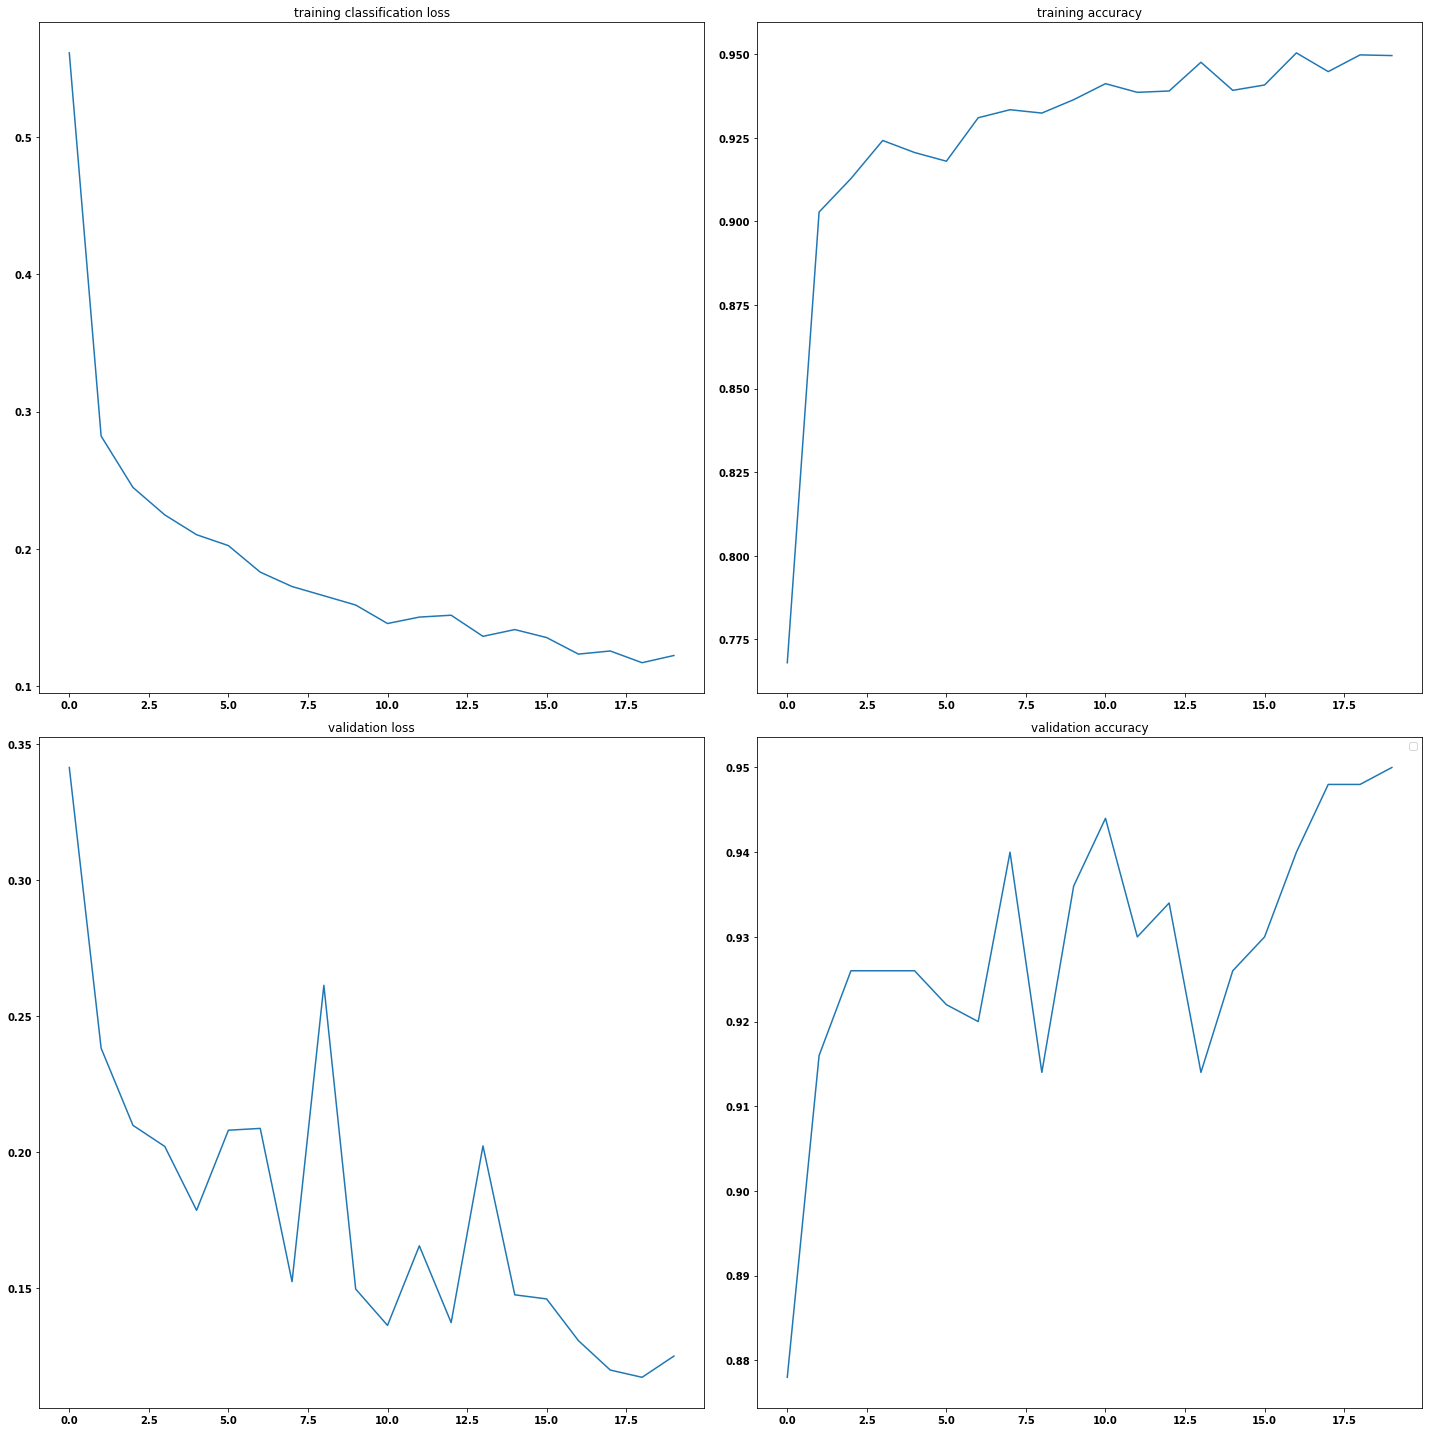

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)
plt.legend()
plt.tight_layout()